# 最適化問題を解くscipy実装：minimize

一般の目的関数$f(x)$を最小化するために，scipyモジュールのminimizeを用いる．

ヤコビ行列とヘッセ行列を用いる最適化手法（ソルバー）があるので，autogradモジュールを用いて関数$f$のヤコビ行列$J$とヘッセ行列$H$を自動微分で計算する．

In [1]:
# モジュールの準備

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from scipy.optimize import minimize, OptimizeResult, minimize_scalar

!pip install autograd
import autograd.numpy as anp # autogradのnumpyの別名をanpにする
from autograd import elementwise_grad as grad
from autograd import jacobian, hessian

# 目的関数$f(x)$の準備


`minimize`では目的関数とそのヤコビ行列，ヘッセ行列を用いる．
まず，これらを一括して定義するためのクラス`objective_func`を定義する．
目的関数`f`はそのクラスのインスタンスとして生成する．

なおこの例の関数はすべて$f: R^2 \to R$である．

In [2]:
class objective_func(object):
    '''
    class for objective functions
    '''

    def __init__(self):

#         0. f(x): R^2 -> R
        def f(x):
            return ((151 * x[0]**2) / 4 -  49 / 2 * np.sqrt(3) * x[0] * x[1] + (53 * x[1]**2) / 4)

#         # 1. f(x): R^2 -> R
#         def f(x):
#             return 3 * (2 * x[0] + x[1])**4 + 5 * x[1]**2

#         # 2. From Boyd & Vandenberghe Eq.(9.20)
#         def f(x):
#             return  anp.exp(x[0] + 3 * x[1] - 0.1) + anp.exp(x[0] - 3 * x[1] - 0.1) + anp.exp(-x[0] - 0.1)
#             # expをつかうときにはautograd.numpyのexpを用いる！

#         # 3. From Boyd & Vandenberghe Fig. 9.2
#         def f(x):
#             return  (x[0] ** 2 + 10 * x[1] ** 2) / 2
        
#         # 4. Rosenbrock function
#         def f(x):
#             return  (1.2 - x[0])**2 + 0.8 * (x[1] - x[0]**2)**2 
    
#         # 5. Styblinski–Tang function
#         def f(x):
#             return  x[0]**4 - 16 * x[0]**2 + 5 * x[0] + \
#             x[1]**4 - 16 * x[1]**2 + 5 * x[1]  + 100
        
        self.f = f
        self.J = grad(f)
        self.H = hessian(f)
        

    def __call__(self, xk):
        '''
        function value f(x_k)
        '''
        return self.f(xk)
    
    def J(self, xk):
        '''
        gradient vector at x_k
        '''
        return self.J(xk)
    
    def H(self, xk):
        '''
        Hessian matrix at x_k
        '''
        return self.H(xk)


# Here define the cost function "f" to be minimized
f = objective_func()

まず$x=(1,1)^T$における関数値が問題なく計算できるかどうかを確認する．

In [3]:
x_check = np.array([1.0, 1.0]) # 数値はfloatにする（autogradは整数を受け付けない）

print("f(x): ", f(x_check))
print("J(x): ", f.J(x_check))
print("H(x): ", f.H(x_check))

f(x):  8.56475521456251
J(x):  [ 33.06475521 -15.93524479]
H(x):  [[ 75.5        -42.43524479]
 [-42.43524479  26.5       ]]


以下は関数$f$の値を2次元プロットで可視化する関数である．

In [4]:
def visualize_f(f, mesh=True, boundary=True, only_zero=False):
    
    # plot range
    x_min = -10
    x_max = +10
    y_min = -10
    y_max = +10
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    #
    # visualizing the cost function f()
    #
    
    # make a grid
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j] 
    # evaluate f() at each point in the grid
    Z = np.array([f(x) for x in np.c_[XX.ravel(), YY.ravel()]])
    Z = Z.reshape(XX.shape) # just reshape form 1D to 2D
    if mesh: # plot f() with color (with very low z-order)
        plt.pcolormesh(XX, YY, Z, cmap=plt.cm.gray_r, zorder=-10)
    if boundary: # plot level lines of f()
        if only_zero: 
            plt.contour(XX, YY, Z, 
                        colors=['b'],
                        linestyles=['-'],
                        levels=[0] )
        else:
            plt.contour(XX, YY, Z, 
                        colors=['k']*10,
                        linestyles=['-']*10,
                        levels=list(np.logspace(0.1, 10, 20)))

可視化する関数$f$を引数に与える．

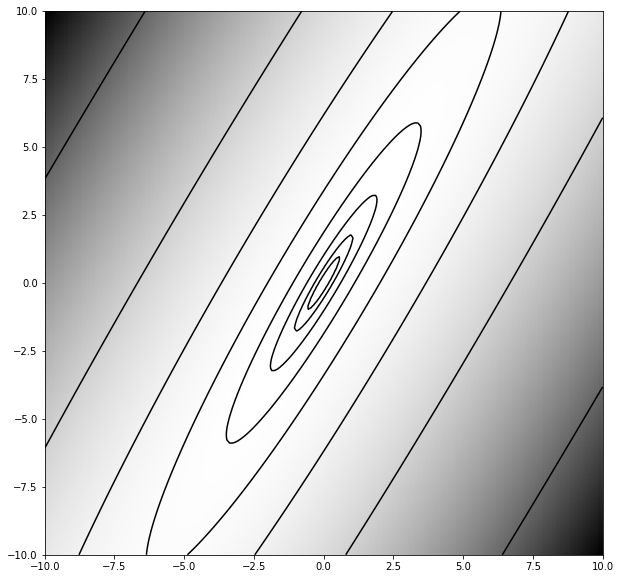

In [5]:
fig = plt.figure(figsize=(10,10))

visualize_f(f)

plt.show()

# 最適化の実行

scipyの`minimize`を用いて目的関数$f(x)$の最小化を実行する．
（参考：[scipy minimization manual](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)）

まず初期値を`x0`とする．

In [6]:
x0 = [4, 6] # 適当に設定

そして最小化を実行する．
`minimize`の

- 第1引数は目的関数`f`（インスタンス），
- 第2引数は初期値`x0`である．

キーワード引数として，

- `jac`には`f`の勾配ベクトルを計算する関数，
- `method`には使用するソルバー名（文字列）を指定する．

（なお`jac`に`'2-point'`を指定すると数値微分で勾配ベクトルを計算する．）

In [7]:
res = minimize(f, x0, jac=f.J, method='BFGS')

返り値`res`には実行時の情報オブジェクト（[OptimizeResult](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult)）が入っている．

- fun: 最適解における目的関数値
- nfev: 関数`f`を評価した（呼び出した）回数
- njev: ヤコビ行列を評価した（呼び出した）回数
- nit: 反復回数
- success: 最小化が成功したかどうか
- x: 最適解

In [8]:
print(res)

      fun: 7.271202982362129e-20
 hess_inv: array([[0.13250319, 0.21218304],
       [0.21218304, 0.37751455]])
      jac: array([-1.48184315e-09,  1.38802328e-09])
  message: 'Optimization terminated successfully.'
     nfev: 8
      nit: 6
     njev: 8
   status: 0
  success: True
        x: array([9.81613202e-11, 2.09566903e-10])


初期解`x0`と最適解を可視化してみる．

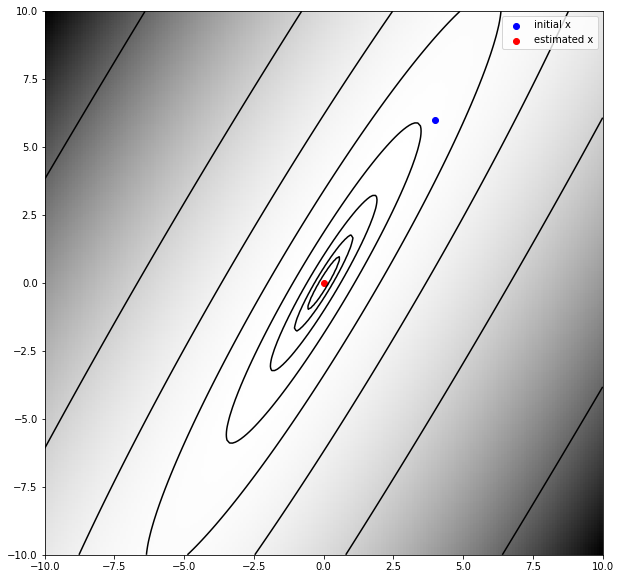

In [9]:
fig = plt.figure(figsize=(10,10))

plt.scatter(x0[0], x0[1], color='blue', label="initial x")
plt.scatter(res.x[0], res.x[1], color="red", label="estimated x")

visualize_f(f)

plt.legend()
plt.show()

初期値と最適解だけでなく，各反復における推定値`xk`も
表示すると，収束の様子がわかる．

そのために，以下のヘルパークラスを定義する．

In [10]:
class fetch_intermediate_x(object):
    '''
    class for fetching x_k values
    '''
    def __init__(self, f, x0):
        self.x_series = [x0]
        self.f_series = [f(x0)]
        self.f = f
        
    def __call__(self, xk):
        self.x_series.append(xk)
        self.f_series.append(self.f(xk))
        
    def get_x_array(self):
        return np.array(self.x_series)

    def get_f_array(self):
        return np.array(self.f_series)

`minimize`のオプション引数`callback`には，毎回の反復で呼び出すコールバック関数を指定できる．そこにこのクラスのインスタンス`fetch`を指定して，途中の推定値を保存する．

In [11]:
x0 = [4, 6]
fetch = fetch_intermediate_x(f, x0) # initialize

res = minimize(f, x0, jac=f.J, method='BFGS', callback=fetch)

途中の推定値もすべて可視化してみる．

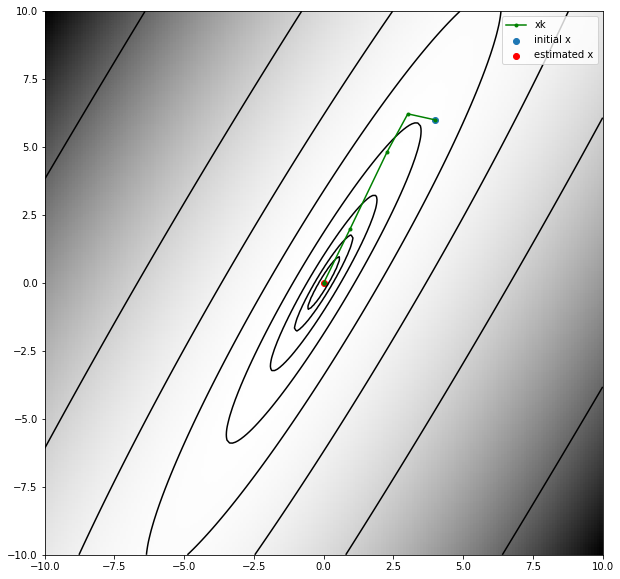

In [12]:
fig = plt.figure(figsize=(10,10))

plt.scatter(x0[0], x0[1], label="initial x")
plt.scatter(res.x[0], res.x[1], color="red", label="estimated x")

x_series = fetch.get_x_array()
plt.plot(x_series[:,0], x_series[:,1], marker='.', color='green', label='xk')
    
visualize_f(f)

plt.legend()
plt.show()

以下では自前のソルバーを実装する．

# 最適化手法の実装

自前のソルバーを実装するには，以下のようなクラスを実装すればよい．
これは非常に単純な最急降下法（gradient decent）を実装している．

実装上の工夫は以下の通り．

- 勾配ベクトルの正規化：関数値が急激に変更する場合には勾配ベクトル（のノルム）が大きくなりすぎるので，ノルムを1に正規化するとよいことが多い．
- ステップサイズを反復回数$k$に反比例，つまり$1/k$にする．固定ステップサイズでは振動する事がある．

In [13]:
class gradientDecent(object):
    '''
    class for gradient methods
    THIS IS THE CLASS you have to implement
    '''
    def __init__(self):
        self.x_series = []
        self.f_series = []
        self.g_series = []
        
        
    def __call__(self, f, x0, callback, **options):

        x = x0 # initialize

        n_iter = options['maxiter'] if 'maxiter' in options else 100
        alpha0 = options['alpha0'] if 'alpha0' in options else 1 # initial step size (learning rate)

            
        for i in range(n_iter):

            function_value = f(x) # f: objective function value
            gradient = f.J(x) # J: gradient vector
#             hessian = f.H(x) # H: hessian matrix

            self.x_series.append(x)
            self.f_series.append(function_value)
            self.g_series.append(gradient)


            ######################
            # implementation below
            ######################

#             gradient /= np.linalg.norm(gradient) # make gradient be a unit vector
#             alpha = alpha0 / (nit+1) # step size with 1/t decay
            alpha = alpha0 # constant step size

            x = x - alpha * gradient

            ######################
            # implementation above
            ######################

            
            callback(x) # pass the new x in the callback function


        result = OptimizeResult() # create a result object
        result.x = x # estimated x
        result.success = True # if converges else False
        result.nit = n_iter # numer of iterations
        result.fun = f(x) # final function value

        return result
    
    
    def name(self):
        return 'gradient decent'

このクラスのインスタンスを`myGD`とする．

In [14]:
myGD = gradientDecent()

このインスタンスを`minimize`の`method`引数に指定すれば，このソルバーを用いた最適化が実行できる．

In [15]:
x0 = [4, 6]
fetch = fetch_intermediate_x(f, x0) # initialize

res = minimize(f, x0, method=myGD, jac=f.J, callback=fetch, options={'alpha0': 1e-4})

収束の様子を可視化する．

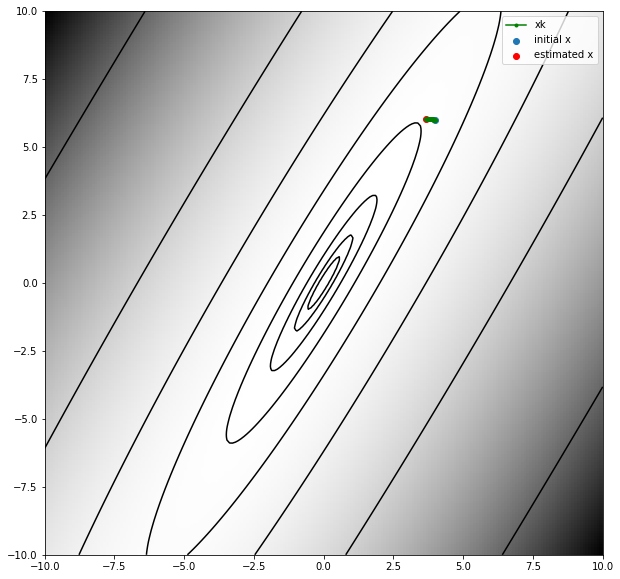

In [16]:
fig = plt.figure(figsize=(10,10))

plt.scatter(x0[0], x0[1], label="initial x")
plt.scatter(res.x[0], res.x[1], color="red", label="estimated x")

x_series = fetch.get_x_array()
plt.plot(x_series[:,0], x_series[:,1], marker='.', color='green', label='xk')
    
visualize_f(f)

plt.legend()
plt.show()

単純な勾配法ではこの関数の最小値を見つけることはできていない．

# 様々なソルバーの比較

以下は，様々なソルバーで同じ問題を解いた場合の結果の比較である．

In [17]:
# random initial solution
# x0 = np.random.rand(2)*20 - 10 # [-5,+5]^2
x0 = [4,6]

results_dic = {}

for m,j,h in [
#     without gradient
    ('Nelder-Mead', None, None),
    ('Powell', None, None),
#     gradient
    ('BFGS', f.J, None),
    ('L-BFGS-B', f.J, None),
    ('CG', f.J, None),
    ('TNC', f.J, None),
#     Hessian and gradient
    ('Newton-CG', f.J, f.H),
    ('trust-ncg', f.J, f.H),
    ('dogleg', f.J, f.H),
#     your own custom solver
    (myGD, f.J, f.H)
    ]:

    fetch = fetch_intermediate_x(f, x0) # initialize

    res = minimize(f, x0,
                   jac=j,
                   hess=h,
                   method=m, 
                   callback=fetch)
    
    x_series = fetch.get_x_array()
    f_series = fetch.get_f_array()

    method_name = (m if type(m) == str else m.name())

    label_str = method_name + " (%d itrs, min=%.3e)" % (res.nit, res.fun)
    
    results_dic[method_name] = (x_series, f_series, res.nit, res.fun)
    

/Users/tamaki/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/tamaki/opt/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in multiply
  return f_raw(*args, **kwargs)
/Users/tamaki/opt/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)


収束の様子を可視化する．

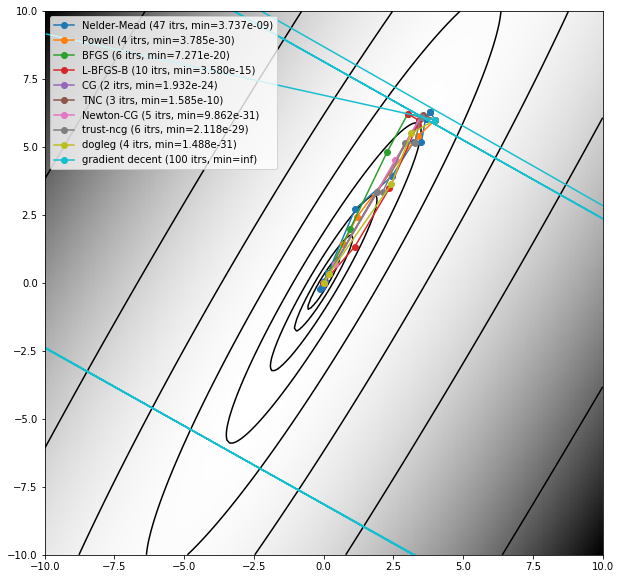

In [18]:
fig = plt.figure(figsize=(10,10))

for method_name, v in results_dic.items():

    x_series = v[0]
    label_str = method_name + " (%d itrs, min=%.3e)" % (v[2], v[3])

    plt.plot(x_series[:,0], x_series[:,1], 
             marker="o", 
             label=label_str)

visualize_f(f)
plt.legend()
plt.show()

目的関数値の減少の様子をプロットする．

/Users/tamaki/opt/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:6759: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


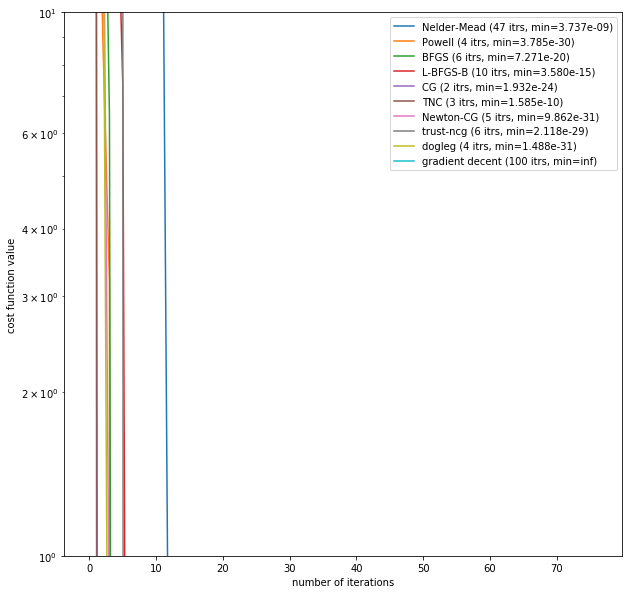

In [19]:
fig = plt.figure(figsize=(10,10))

for method_name, v in results_dic.items():

    f_series = v[1]
    label_str = method_name + " (%d itrs, min=%.3e)" % (v[2], v[3])

    # plot solution series
    plt.plot(range(len(f_series)), f_series, 
             label=label_str)

plt.legend()
plt.xlabel("number of iterations")
plt.ylabel("cost function value")
plt.yscale("log")
plt.show()

# Task

## 検証

関数1から5までに対して，最急降下法の反復回数を100に固定し，
以下の事項を変更して収束の様子をプロットし，議論せよ．
- 初期ステップサイズalpha0：1e-7〜1e+0
- 勾配を正規化する・しない
- 固定ステップサイズ・可変ステップサイズ（$1/k$）




## 実装 
`gradientMethod`クラスの実装を変更して，以下の手法を実装する．
そして，収束の様子の可視化と，関数値の減少の様子のプロットから，
それぞれがどのような振る舞いをしているのかを議論する．

- 停止条件を実装する．最大反復回数が指定されているときはその回数で終了する．そうでない場合には，現在の推定値$x_k$と前回の推定値$x_{k-1}$の差が十分に小さいなら（$\| x_k - x_{k-1} \| \le 1e-7$）停止する．
 - 最急降下法
 - 最急降下法＋慣性項（$\mu=0.9$程度）
 - Nesterovの加速勾配法
 - ニュートン法
- 直線探索を実装する（停止条件も実装）．１次元探索には[scipy.optimize.minimize_scalar](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html#scipy.optimize.minimize_scalar)を用いる．
 - 最急降下法
 - ニュートン法


## 最急降下法＋停止条件

In [20]:
class gradientDecentSC(object):
    '''
    class for gradient decent with stopping condition
    '''
    def __init__(self):
        self.x_series = []
        self.f_series = []
        self.g_series = []
        
        
    def __call__(self, f, x0, callback, **options):

        x = x0 # initialize

        n_iter = options['maxiter'] if 'maxiter' in options else 1000
        alpha0 = options['alpha0'] if 'alpha0' in options else 1 # initial step size (learning rate)
        xtol = options['xtol'] if 'xtol' in options else 1e-7 # torrelance of x for stopping condition

        nit = 0 # actual iterations
        x_pre = x # x is x_k, x_pre is x_{k-1}

        for i in range(n_iter):

            function_value = f(x) # f: objective function value
            gradient = f.J(x) # J: gradient vector
#             hessian = f.H(x) # H: hessian matrix

            self.x_series.append(x)
            self.f_series.append(function_value)
            self.g_series.append(gradient)


            ######################
            # implementation below
            ######################
            
            gradient /= np.linalg.norm(gradient) # make gradient be a unit vector
            
            alpha = alpha0 / (nit+1) # step size with 1/t decay
            
            x = x - alpha * gradient
            
            ######################
            # implementation above
            ######################

            
            callback(x) # pass the new x in the callback function
            
            if np.linalg.norm(x - x_pre) < xtol: # stop when ||x_k - x_{k-1} || < 1e-7
                break
            x_pre = x
            nit += 1

        result = OptimizeResult() # create a result object
        result.x = x # estimated x
        result.success = True # if converges else False
        result.nit = nit # numer of iterations
        result.fun = f(x) # final function value

        return result
    
    
    def name(self):
        return 'gradient decent with stoppting condition'

In [21]:
myGDSC = gradientDecentSC()

x0 = [4, 4]
fetch = fetch_intermediate_x(f, x0) # initialize

res = minimize(f, x0, method=myGDSC, jac=f.J, callback=fetch, options={'alpha0':1})

In [22]:
res.nit

1000

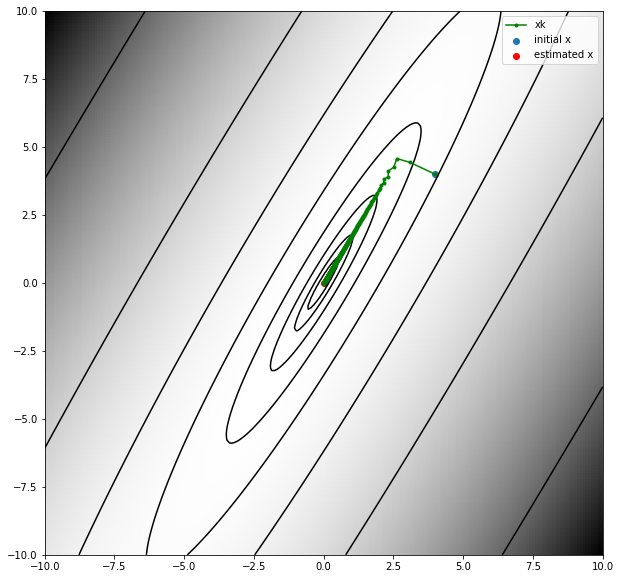

In [23]:
fig = plt.figure(figsize=(10,10))

plt.scatter(x0[0], x0[1], label="initial x")
plt.scatter(res.x[0], res.x[1], color="red", label="estimated x")

x_series = fetch.get_x_array()
plt.plot(x_series[:,0], x_series[:,1], marker='.', color='green', label='xk')
    
visualize_f(f)

plt.legend()
plt.savefig('gdsc.png', dpi=150)
plt.show()

## 最急降下法＋直線探索

In [24]:
class gradientDecentSCLS(object):
    '''
    class for gradient decent with stopping condition and LS
    '''
    def __init__(self):
        self.x_series = []
        self.f_series = []
        self.g_series = []

        # for line search
        self.dir = None
        self.f = None
        self.xk = None
    
        
    def __call__(self, f, x0, callback, **options):

        def line_search_func(alpha):
#             print('alpha:', alpha)
#             print('dir:', self.dir)
#             print('f:', self.f(self.xk - alpha * self.dir))
            return self.f(self.xk - alpha * self.dir)

        x = x0 # initialize
        self.f = f # for line search

        n_iter = options['maxiter'] if 'maxiter' in options else 50
        alpha0 = options['alpha0'] if 'alpha0' in options else 1 # initial step size (learning rate)
        xtol = options['xtol'] if 'xtol' in options else 1e-7 # torrelance of x for stopping condition

        nit = 0 # actual iterations
        x_pre = x # x is x_k, x_pre is x_{k-1}

        for i in range(n_iter):

            function_value = f(x) # f: objective function value
            gradient = f.J(x) # J: gradient vector
#             hessian = f.H(x) # H: hessian matrix

            self.x_series.append(x)
            self.f_series.append(function_value)
            self.g_series.append(gradient)


            ######################
            # implementation below
            ######################
                      
            gradient /= np.linalg.norm(gradient) # make gradient be a unit vector

            # line search
            self.dir = gradient
            self.xk = x
            res_k = minimize_scalar(line_search_func)
            alpha = res_k.x
            
            x = x - alpha * self.dir # gradient decent
            
            ######################
            # implementation above
            ######################

            
            callback(x) # pass the new x in the callback function
            
            if np.linalg.norm(x - x_pre) < xtol: # stop when ||x_k - x_{k-1} || < 1e-7
                break
            x_pre = x
            nit += 1

        result = OptimizeResult() # create a result object
        result.x = x # estimated x
        result.success = True # if converges else False
        result.nit = nit # numer of iterations
        result.fun = f(x) # final function value

        return result
    
    
    def name(self):
        return 'gradient decent with stoppting condition and line search'

In [25]:
myGDSCLS = gradientDecentSCLS()

x0 = [4, 6]
fetch = fetch_intermediate_x(f, x0) # initialize

res = minimize(f, x0, method=myGDSCLS, jac=f.J, callback=fetch)

In [26]:
res.nit

50

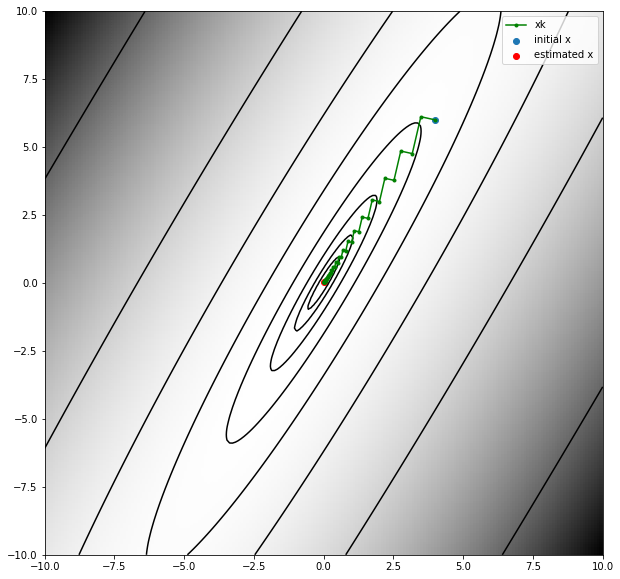

In [27]:
fig = plt.figure(figsize=(10,10))

plt.scatter(x0[0], x0[1], label="initial x")
plt.scatter(res.x[0], res.x[1], color="red", label="estimated x")

x_series = fetch.get_x_array()
plt.plot(x_series[:,0], x_series[:,1], marker='.', color='green', label='xk')
    
visualize_f(f)

plt.legend()
plt.savefig('gdscls.png', dpi=150)
plt.show()

## ニュートン法＋停止条件

In [28]:
class NewtonSC(object):
    '''
    class for Newton's method with stopping condition
    '''
    def __init__(self):
        self.x_series = []
        self.f_series = []
        self.g_series = []
        
        
    def __call__(self, f, x0, callback, **options):

        x = x0 # initialize

        n_iter = options['maxiter'] if 'maxiter' in options else 1000
        alpha0 = options['alpha0'] if 'alpha0' in options else 1 # initial step size (learning rate)
        xtol = options['xtol'] if 'xtol' in options else 1e-7 # torrelance of x for stopping condition

        nit = 0 # actual iterations
        x_pre = x # x is x_k, x_pre is x_{k-1}

        for i in range(n_iter):

            function_value = f(x) # f: objective function value
            gradient = f.J(x) # J: gradient vector
            hessian = f.H(x) # H: hessian matrix

            self.x_series.append(x)
            self.f_series.append(function_value)
            self.g_series.append(gradient)


            ######################
            # implementation below
            ######################
            
#             print('xk:', x)
#             print('f:', function_value)
#             print('gradient:', gradient)
#             print('hessian:', hessian)
#             print('det:', np.linalg.det(hessian))
            x = x - np.linalg.inv(hessian) @ gradient # gradient decent
            
            ######################
            # implementation above
            ######################

            
            callback(x) # pass the new x in the callback function
            
            if np.linalg.norm(x - x_pre) < xtol: # stop when ||x_k - x_{k-1} || < 1e-7
                break
            x_pre = x
            nit += 1

        result = OptimizeResult() # create a result object
        result.x = x # estimated x
        result.success = True # if converges else False
        result.nit = nit # numer of iterations
        result.fun = f(x) # final function value

        return result
    
    
    def name(self):
        return "Newton's method with stoppting condition"

In [29]:
myNSC = NewtonSC()

x0 = [4, 6]
fetch = fetch_intermediate_x(f, x0) # initialize

res = minimize(f, x0, method=myNSC, jac=f.J, callback=fetch)

In [30]:
res.nit

1

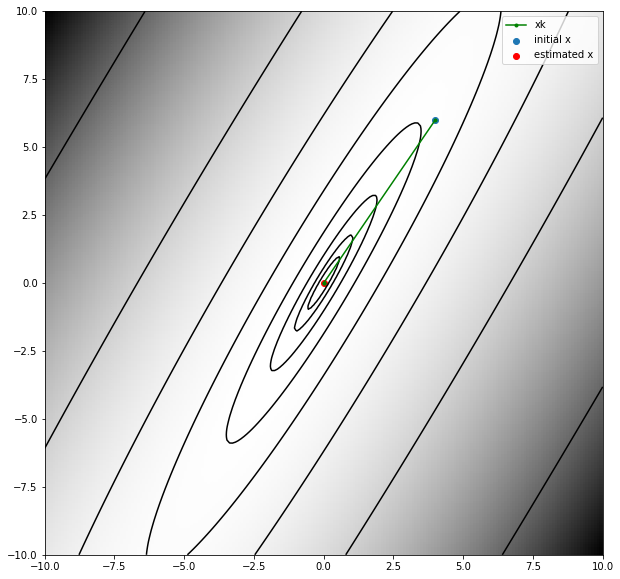

In [31]:
fig = plt.figure(figsize=(10,10))

plt.scatter(x0[0], x0[1], label="initial x")
plt.scatter(res.x[0], res.x[1], color="red", label="estimated x")

x_series = fetch.get_x_array()
plt.plot(x_series[:,0], x_series[:,1], marker='.', color='green', label='xk')
    
visualize_f(f)

plt.legend()
plt.savefig('nsc.png', dpi=150)
plt.show()

## ニュートン法＋直線探索

In [32]:
class NewtonSCLC(object):
    '''
    class for Newton's method with stopping condition and line search
    '''
    def __init__(self):
        self.x_series = []
        self.f_series = []
        self.g_series = []

        # for line search
        self.dir = None
        self.f = None
        self.xk = None
        self.Hinv = None
    
        
    def __call__(self, f, x0, callback, **options):

        def line_search_func(alpha):
#             print('alpha:', alpha)
#             print('dir:', self.dir)
#             print('f:', self.f(self.xk - alpha * self.dir))
            return self.f(self.xk - alpha * self.dir)

        x = x0 # initialize
        self.f = f # for line search

        n_iter = options['maxiter'] if 'maxiter' in options else 50
        alpha0 = options['alpha0'] if 'alpha0' in options else 1 # initial step size (learning rate)
        xtol = options['xtol'] if 'xtol' in options else 1e-7 # torrelance of x for stopping condition

        nit = 0 # actual iterations
        x_pre = x # x is x_k, x_pre is x_{k-1}

        for i in range(n_iter):

            function_value = f(x) # f: objective function value
            gradient = f.J(x) # J: gradient vector
            hessian = f.H(x) # H: hessian matrix

            self.x_series.append(x)
            self.f_series.append(function_value)
            self.g_series.append(gradient)


            ######################
            # implementation below
            ######################
                      
            self.Hinv = np.linalg.inv(hessian)
           
            # line search
            self.dir = self.Hinv @ gradient
            self.xk = x
            res_k = minimize_scalar(line_search_func)
            alpha = res_k.x
            
            x = x - alpha * self.dir
            
            ######################
            # implementation above
            ######################

            
            callback(x) # pass the new x in the callback function
            
            if np.linalg.norm(x - x_pre) < xtol: # stop when ||x_k - x_{k-1} || < 1e-7
                break
            x_pre = x
            nit += 1

        result = OptimizeResult() # create a result object
        result.x = x # estimated x
        result.success = True # if converges else False
        result.nit = nit # numer of iterations
        result.fun = f(x) # final function value

        return result
    
    
    def name(self):
        return "Newton's method with stoppting condition and line search"

In [33]:
myNSCLS = NewtonSCLC()

x0 = [4, 6]
fetch = fetch_intermediate_x(f, x0) # initialize

res = minimize(f, x0, method=myNSCLS, jac=f.J, callback=fetch)

In [34]:
res.nit

1

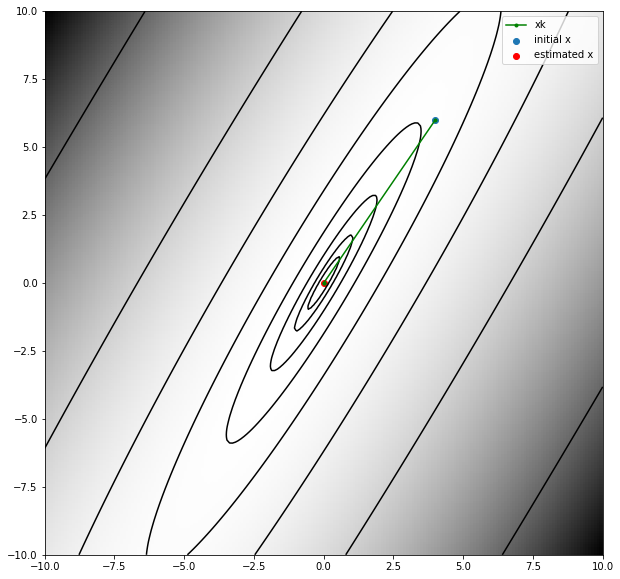

In [35]:
fig = plt.figure(figsize=(10,10))

plt.scatter(x0[0], x0[1], label="initial x")
plt.scatter(res.x[0], res.x[1], color="red", label="estimated x")

x_series = fetch.get_x_array()
plt.plot(x_series[:,0], x_series[:,1], marker='.', color='green', label='xk')
    
visualize_f(f)

plt.legend()
plt.savefig('nscls.png', dpi=150)
plt.show()

## 最急降下法＋慣性項＋停止条件

In [36]:
class gradientDecentSCM(object):
    '''
    class for gradient decent with stopping condition and momentum
    '''
    def __init__(self):
        self.x_series = []
        self.f_series = []
        self.g_series = []
        
        
    def __call__(self, f, x0, callback, **options):

        x = x0 # initialize

        n_iter = options['maxiter'] if 'maxiter' in options else 1000
        alpha0 = options['alpha0'] if 'alpha0' in options else 1 # initial step size (learning rate)
        xtol = options['xtol'] if 'xtol' in options else 1e-7 # torrelance of x for stopping condition
        mu = options['mu'] if 'mu' in options else 0.9

        nit = 0 # actual iterations
        x_pre = x # x is x_k, x_pre is x_{k-1}
        d_pre = np.zeros(x.shape)
        
        for i in range(n_iter):

            function_value = f(x) # f: objective function value
            gradient = f.J(x) # J: gradient vector
#             hessian = f.H(x) # H: hessian matrix

            self.x_series.append(x)
            self.f_series.append(function_value)
            self.g_series.append(gradient)


            ######################
            # implementation below
            ######################
            
            gradient /= np.linalg.norm(gradient) # make gradient be a unit vector
            
            alpha = alpha0 / (nit+1) # step size with 1/t decay
            
            d = - alpha * gradient + mu * d_pre

            x = x + d
            
            d_pre = d
            
            ######################
            # implementation above
            ######################

            
            callback(x) # pass the new x in the callback function
            
            if np.linalg.norm(x - x_pre) < xtol: # stop when ||x_k - x_{k-1} || < 1e-7
                break
            x_pre = x
            nit += 1

        result = OptimizeResult() # create a result object
        result.x = x # estimated x
        result.success = True # if converges else False
        result.nit = nit # numer of iterations
        result.fun = f(x) # final function value

        return result
    
    
    def name(self):
        return 'gradient decent with stoppting condition and momentum'

    
myGDSCM = gradientDecentSCM()

In [37]:
x0 = [4, 6]
fetch = fetch_intermediate_x(f, x0) # initialize

res = minimize(f, x0, method=myGDSCM, jac=f.J, callback=fetch, options={'alpha0':1})

In [38]:
res.nit

1000

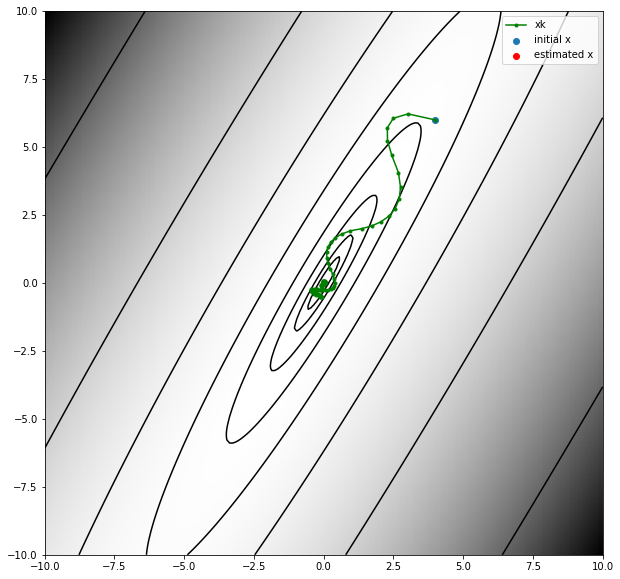

In [39]:
fig = plt.figure(figsize=(10,10))

plt.scatter(x0[0], x0[1], label="initial x")
plt.scatter(res.x[0], res.x[1], color="red", label="estimated x")

x_series = fetch.get_x_array()
plt.plot(x_series[:,0], x_series[:,1], marker='.', color='green', label='xk')
    
visualize_f(f)

plt.legend()
plt.savefig('gdscm.png', dpi=150)
plt.show()

## NAG＋停止条件

In [40]:
class NAG(object):
    '''
    class for Nesterov's accelerated gradient, with stopping condition
    '''
    def __init__(self):
        self.x_series = []
        self.f_series = []
        self.g_series = []
        
        
    def __call__(self, f, x0, callback, **options):

        x = x0 # initialize

        n_iter = options['maxiter'] if 'maxiter' in options else 1000
        alpha0 = options['alpha0'] if 'alpha0' in options else 1 # initial step size (learning rate)
        xtol = options['xtol'] if 'xtol' in options else 1e-7 # torrelance of x for stopping condition
        mu = options['mu'] if 'mu' in options else 0.9

        nit = 0 # actual iterations
        x_pre = x # x is x_k, x_pre is x_{k-1}
        d_pre = np.zeros(x.shape)
        
        for i in range(n_iter):

            ######################
            # implementation below
            ######################
            
            k = nit + 1
            mu = (k - 1) / (k+2)

            function_value = f(x) # f: objective function value
            y = x + mu * d_pre

            gradient = f.J(y)

            
            self.x_series.append(x)
            self.f_series.append(function_value)
            self.g_series.append(gradient)


            gradient /= np.linalg.norm(gradient) # make gradient be a unit vector
            
            alpha = alpha0 / (nit+1) # step size with 1/t decay
            
            d = - alpha * gradient + mu * d_pre

            x = x + d
            
            d_pre = d
            
            ######################
            # implementation above
            ######################

            
            callback(x) # pass the new x in the callback function
            
            if np.linalg.norm(x - x_pre) < xtol: # stop when ||x_k - x_{k-1} || < 1e-7
                break
            x_pre = x
            nit += 1

        result = OptimizeResult() # create a result object
        result.x = x # estimated x
        result.success = True # if converges else False
        result.nit = nit # numer of iterations
        result.fun = f(x) # final function value

        return result
    
    
    def name(self):
        return 'gradient decent with stoppting condition and momentum'

    
myNAG = NAG()

In [41]:
x0 = [4, 6]
fetch = fetch_intermediate_x(f, x0) # initialize

res = minimize(f, x0, method=myNAG, jac=f.J, callback=fetch, options={'alpha0':1})

In [42]:
res.nit

1000

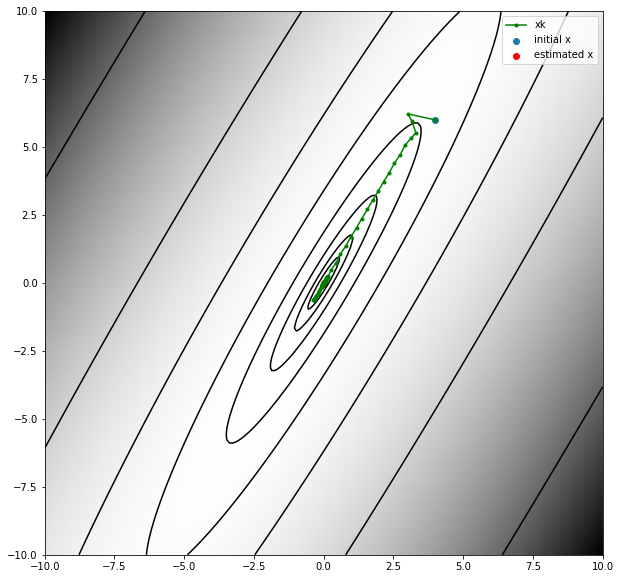

In [43]:
fig = plt.figure(figsize=(10,10))

plt.scatter(x0[0], x0[1], label="initial x")
plt.scatter(res.x[0], res.x[1], color="red", label="estimated x")

x_series = fetch.get_x_array()
plt.plot(x_series[:,0], x_series[:,1], marker='.', color='green', label='xk')
    
visualize_f(f)

plt.legend()
plt.savefig('nagsc.png', dpi=150)
plt.show()